In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys

sys.path.append("../")

from src.common_functions import *

In [3]:
# sample data
# RAW_DATA_PATH = "../datasets/fraud/fin_fraud.csv"
SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_1.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data = pd.read_csv(RAW_DATA_PATH)
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.1, random_state=42, stratify=raw_data["fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH)
print(df.shape[0])
df.fraud.value_counts()/df.shape[0]*100

100000


fraud
0.0    91.26
1.0     8.74
Name: count, dtype: float64

In [4]:
df.isna().any()

Unnamed: 0                        False
distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

In [5]:
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,748493,40.751310,1.640059,0.563163,1.0,1.0,0.0,1.0,0.0
1,924852,1.282625,0.104560,0.349388,0.0,0.0,0.0,0.0,0.0
2,421808,20.369739,0.059844,0.327433,1.0,1.0,0.0,1.0,0.0
3,526416,10.537379,0.960467,0.232489,1.0,0.0,0.0,0.0,0.0
4,152659,8.519601,0.266422,3.804493,1.0,0.0,0.0,0.0,0.0


In [6]:
y = "fraud"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [7]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2160 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.9796184464510809
Best parameters: {'logistic__C': 1, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 8, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  [])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=8)),
                ('logistic', LogisticRegression(C=1))])

In [8]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [9]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,6,1,l2,0.970625,0.002604
144,0.1,0.2,6,10,l2,0.969910,0.003157
288,0.1,0.2,6,100,l2,0.969844,0.002507
432,0.1,0.2,6,1000,l2,0.971550,0.002168
6,0.1,0.2,8,1,l2,0.973713,0.002795
...,...,...,...,...,...,...,...
556,0.7,1.0,6,1000,l2,0.966691,0.000546
130,0.7,1.0,8,1,l2,0.979618,0.000790
274,0.7,1.0,8,10,l2,0.979382,0.000825
418,0.7,1.0,8,100,l2,0.979323,0.000934


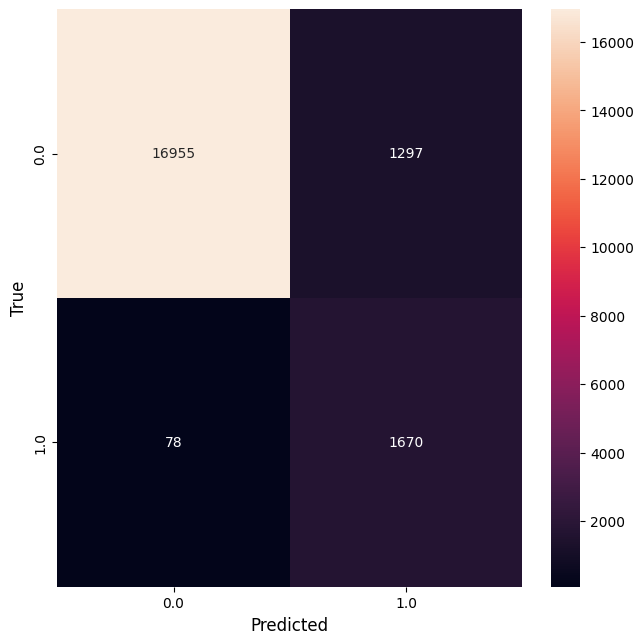

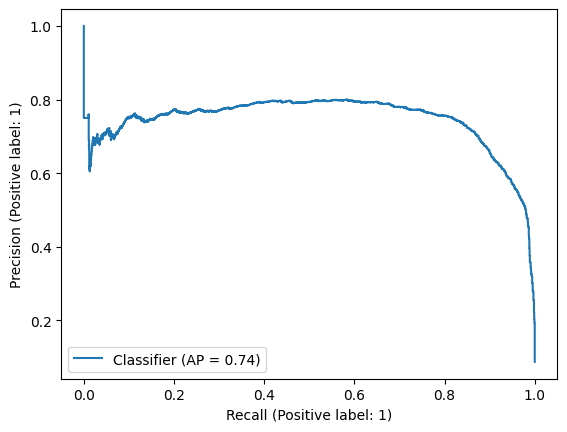

In [10]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name= 'logistic')

In [11]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [8, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9998350266165745
Best parameters: {'xgb__subsample': 0.6, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 5, 'xgb__max_depth': 4, 'xgb__gamma': 2, 'xgb__colsample_bytree': 0.8, 'under__sampling_strategy': 0.1, 'pca__n_components': 8, 'over__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(ste...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [12]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

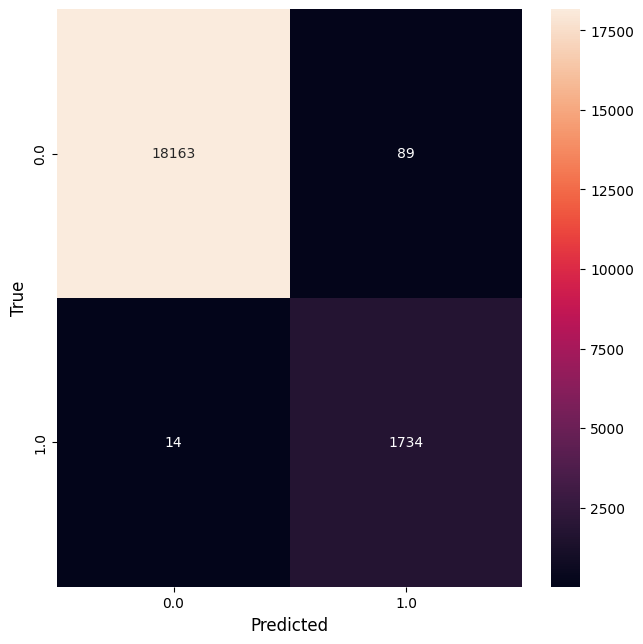

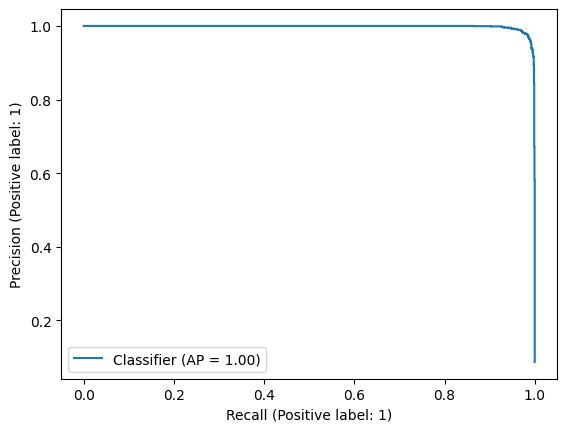

In [13]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [14]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [30]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a*10


test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["ratio_to_median_purchase_price"]).to_frame())[:, 0]

# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")

Test cost/loss = 3323.


In [31]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a*10


test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["ratio_to_median_purchase_price"]).to_frame())[:, 0]

# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")

Test cost/loss = 665.


# e-amc

In [40]:
cb_column = 'cb'
test[cb_column]= (test['ratio_to_median_purchase_price'])

test['TN'] = 0
test['FN'] = -test[cb_column]*10
test['FP'] = -1
test['TP'] = 0

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)


c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [18]:
test

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,cb,TN,FN,FP,TP,prob_churn,EAP,EP
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0.271620,0,2.716200,1,1,2.471419e-08,0.005628,0.087400
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,1.314701,0,13.147013,1,1,1.702196e-05,0.166147,0.087400
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,1.464470,0,14.644695,1,1,1.151681e-05,0.145652,0.087400
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,1.016061,0,10.160605,1,1,1.184258e-07,0.000218,0.087400
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0.429776,0,4.297764,1,1,1.341525e-06,0.046775,0.087400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,4.742546,0,47.425457,1,1,9.998353e-01,6.541547,43.367872
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,4.021248,0,40.212478,1,1,5.401319e-01,10.629941,36.785308
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,14.330479,0,143.304793,1,1,9.997148e-01,1.000054,130.867354
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,19.370925,0,193.709251,1,1,9.999229e-01,1.000000,176.866462


In [41]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

-7471.374896190649
-92684.69795145269
EAP :  -0.37356874480953245
EP :  -4.634234897572634


In [42]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

-1335.8971400059913
-92684.69795145269
EAP :  -0.06679485700029957
EP :  -4.634234897572634


# AMC

Decision Threshold: 0.01, Test cost/loss = 10369.00
Decision Threshold: 0.02, Test cost/loss = 9160.00
Decision Threshold: 0.03, Test cost/loss = 7964.00
Decision Threshold: 0.04, Test cost/loss = 7025.10
Decision Threshold: 0.05, Test cost/loss = 6411.43
Decision Threshold: 0.06, Test cost/loss = 5937.80
Decision Threshold: 0.07, Test cost/loss = 5494.80
Decision Threshold: 0.08, Test cost/loss = 5207.65
Decision Threshold: 0.09, Test cost/loss = 4900.65
Decision Threshold: 0.10, Test cost/loss = 4722.14
Decision Threshold: 0.11, Test cost/loss = 4507.28
Decision Threshold: 0.12, Test cost/loss = 4406.75
Decision Threshold: 0.13, Test cost/loss = 4196.75
Decision Threshold: 0.14, Test cost/loss = 4090.27
Decision Threshold: 0.15, Test cost/loss = 4036.58
Decision Threshold: 0.16, Test cost/loss = 3948.11
Decision Threshold: 0.17, Test cost/loss = 3812.11
Decision Threshold: 0.18, Test cost/loss = 3815.97
Decision Threshold: 0.19, Test cost/loss = 3714.97
Decision Threshold: 0.20, Test

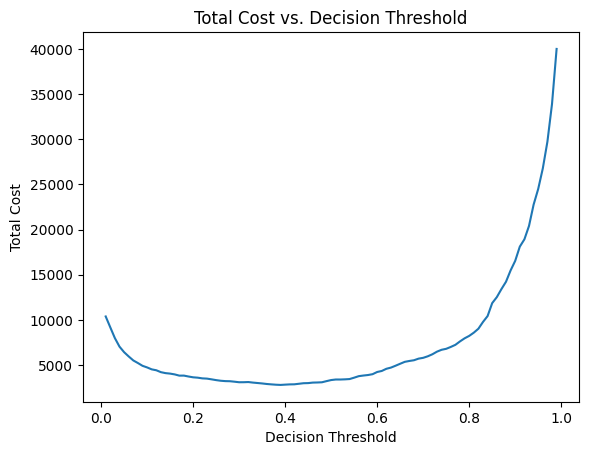

(0.39, 0.13915906236913683, 2783.1812473827367)

In [43]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = 808.15
Decision Threshold: 0.02, Test cost/loss = 636.15
Decision Threshold: 0.03, Test cost/loss = 561.15
Decision Threshold: 0.04, Test cost/loss = 505.15
Decision Threshold: 0.05, Test cost/loss = 469.15
Decision Threshold: 0.06, Test cost/loss = 434.15
Decision Threshold: 0.07, Test cost/loss = 411.83
Decision Threshold: 0.08, Test cost/loss = 387.83
Decision Threshold: 0.09, Test cost/loss = 371.83
Decision Threshold: 0.10, Test cost/loss = 358.83
Decision Threshold: 0.11, Test cost/loss = 345.83
Decision Threshold: 0.12, Test cost/loss = 336.83
Decision Threshold: 0.13, Test cost/loss = 325.83
Decision Threshold: 0.14, Test cost/loss = 317.83
Decision Threshold: 0.15, Test cost/loss = 310.83
Decision Threshold: 0.16, Test cost/loss = 302.83
Decision Threshold: 0.17, Test cost/loss = 301.86
Decision Threshold: 0.18, Test cost/loss = 296.86
Decision Threshold: 0.19, Test cost/loss = 290.86
Decision Threshold: 0.20, Test cost/loss = 288.86


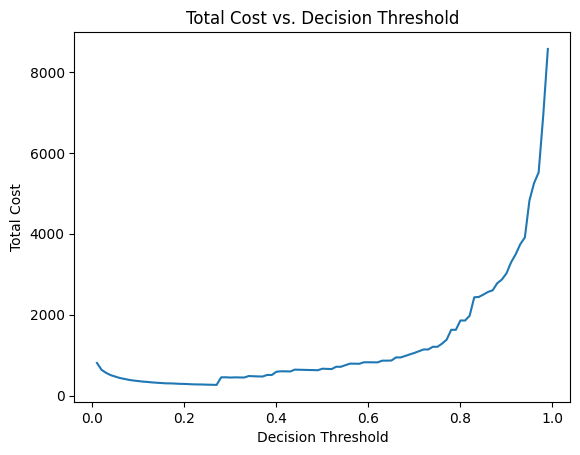

(0.27, 0.0131931568750785, 263.86313750157)

In [44]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')

# Emp

In [45]:
cb_column = 'cb'
test[cb_column]= (test['ratio_to_median_purchase_price'])

test['TN'] = 0
test['FN'] = -test[cb_column]*10
test['FP'] = -1
test['TP'] = -1 +test[cb_column]*10

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_predictions_xgb= add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)


c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [24]:
test

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0.271620,0,-2.716200,-1,1.716200,2.471419e-08,-0.005628,-0.087400,0.005628,0.000000
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,1.314701,0,-13.147013,-1,12.147013,1.702196e-05,-0.166147,-0.087400,0.166147,0.000000
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,1.464470,0,-14.644695,-1,13.644695,1.151681e-05,-0.145652,-0.087400,0.145652,0.000000
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,1.016061,0,-10.160605,-1,9.160605,1.184258e-07,-0.000218,-0.087400,0.000218,0.000000
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0.429776,0,-4.297764,-1,3.297764,1.341525e-06,-0.046775,-0.087400,0.046775,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,4.742546,0,-47.425457,-1,46.425457,9.998353e-01,35.222998,-39.222887,0.880636,47.425457
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,4.021248,0,-40.212478,-1,39.212478,5.401319e-01,19.707013,-33.270737,0.754416,40.212478
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,14.330479,0,-143.304793,-1,142.304793,9.997148e-01,142.304685,-118.342516,1.000000,1.000000
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,19.370925,0,-193.709251,-1,192.709251,9.999229e-01,192.709250,-159.936274,1.000000,1.000000


In [25]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

85270.08223652167
-84113.80456342183
EAP :  4.263504111826084
EP :  -4.2056902281710915


In [26]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

95549.89480814885
-84113.80456342183
EAP :  4.777494740407443
EP :  -4.2056902281710915


# MP

In [27]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1 - a*10
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a*10

Decision Threshold: 0.01, Test cost/loss = -87696.14
Decision Threshold: 0.02, Test cost/loss = -88905.14
Decision Threshold: 0.03, Test cost/loss = -90101.14
Decision Threshold: 0.04, Test cost/loss = -91038.95
Decision Threshold: 0.05, Test cost/loss = -91613.28
Decision Threshold: 0.06, Test cost/loss = -92044.55
Decision Threshold: 0.07, Test cost/loss = -92487.55
Decision Threshold: 0.08, Test cost/loss = -92684.85
Decision Threshold: 0.09, Test cost/loss = -92991.85
Decision Threshold: 0.10, Test cost/loss = -93084.87
Decision Threshold: 0.11, Test cost/loss = -93258.57
Decision Threshold: 0.12, Test cost/loss = -93265.65
Decision Threshold: 0.13, Test cost/loss = -93475.65
Decision Threshold: 0.14, Test cost/loss = -93497.60
Decision Threshold: 0.15, Test cost/loss = -93450.98
Decision Threshold: 0.16, Test cost/loss = -93484.93
Decision Threshold: 0.17, Test cost/loss = -93620.93
Decision Threshold: 0.18, Test cost/loss = -93506.21
Decision Threshold: 0.19, Test cost/loss = -93

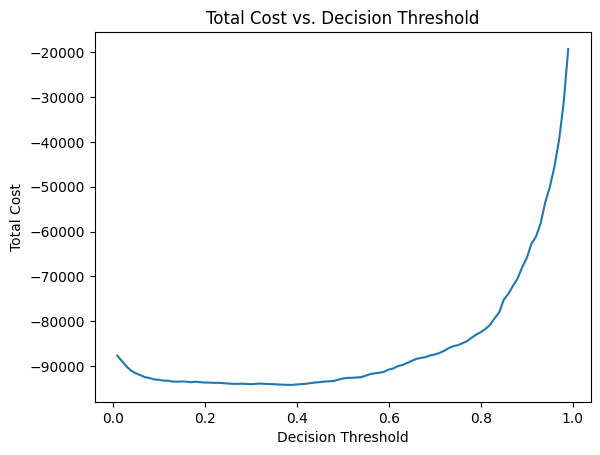

(0.39, -4.710888962235905, -94217.7792447181)

In [28]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = -97170.83
Decision Threshold: 0.02, Test cost/loss = -97342.83
Decision Threshold: 0.03, Test cost/loss = -97417.83
Decision Threshold: 0.04, Test cost/loss = -97473.83
Decision Threshold: 0.05, Test cost/loss = -97509.83
Decision Threshold: 0.06, Test cost/loss = -97544.83
Decision Threshold: 0.07, Test cost/loss = -97558.48
Decision Threshold: 0.08, Test cost/loss = -97582.48
Decision Threshold: 0.09, Test cost/loss = -97598.48
Decision Threshold: 0.10, Test cost/loss = -97611.48
Decision Threshold: 0.11, Test cost/loss = -97624.48
Decision Threshold: 0.12, Test cost/loss = -97633.48
Decision Threshold: 0.13, Test cost/loss = -97644.48
Decision Threshold: 0.14, Test cost/loss = -97652.48
Decision Threshold: 0.15, Test cost/loss = -97659.48
Decision Threshold: 0.16, Test cost/loss = -97667.48
Decision Threshold: 0.17, Test cost/loss = -97662.42
Decision Threshold: 0.18, Test cost/loss = -97667.42
Decision Threshold: 0.19, Test cost/loss = -97

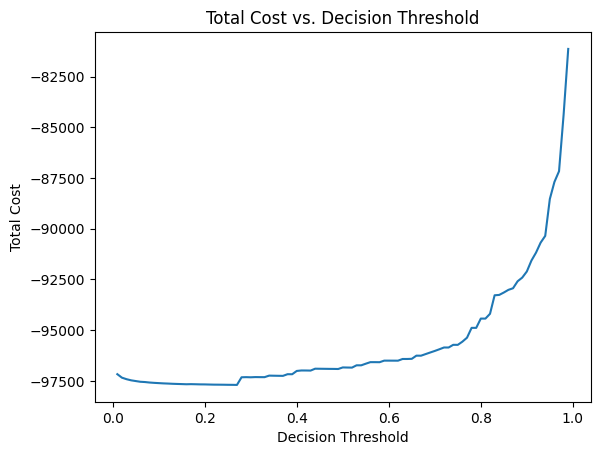

(0.27, -4.885020773224022, -97700.41546448044)

In [29]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')